In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.autograd.profiler as profiler

# TODO difference between these two
from torchdiffeq import odeint_adjoint, odeint  # For ODE solver (CNF)
from torchdyn.core import NeuralODE

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import cProfile

from distributions import *
from plotting import *

Likelihood-Based Inference
----
***

In fact, having access to the likelihood can simplify parts of the process and can be incorporated into the training of the CNF.

Maximum Likelihood Estimation (MLE):
$$
\hat{\theta}=\arg\max_{\theta} p(x_{\text{obs}} | \theta)
$$


Bayesian Inference:

$$
p(\theta|x_{\text{obs}})=\dfrac{p(x_{\text{obs}}|\theta)p_0(\theta)}{p(x_{\text{obs}})}
$$

Variational Inference:

- Approximate posterior dist
$p(\theta|x_{\text{obs}})$ using simpler, parametric distribution 
$q(\theta)$. Goal is to maximize KL Divergence between
$q(\theta)$ and the true posterior, which includes both the likelihood and the prior

MCMC:

- Used for <u>sampling from the posterior distribution</u> 
$p(\theta|x_{\text{obs}})$ when the likelihood cannot be computed analytically


Likelihood-based Inference with Normalizing Flows
----
***

The term "amortized" comes from the idea that the computational cost of inference is "amortized" over multiple observations, meaning that once the neural network is trained, inference is fast compared to traditional methods like Markov Chain Monte Carlo (MCMC), which require recomputation for every new observation.


Likelihood and Flow-Based Hierarchical Bayesian Inference
---- 
***

In hierarchical Bayesian inference, the posterior you're trying to approximate can be extremely complex because it accounts for both data-level and population-level parameters. CNFs can help in two ways:

Here’s how you can think about the process step-by-step:

1. Define a Prior and Likelihood:
-  Start with the usual Bayesian setup where you have a prior distribution over parameters and a likelihood function.
-  For hierarchical models, you’ll have priors for both data- and population-level parameters.
-  

Use gradient-based optimization (e.g., stochastic gradient descent)


Data Simulation
----
***

In [2]:
def forward_model(k, th, ph):
    """
    Data simulator

    Maybe we create A4s using k, th, ph. Then, we train a model to invert this, given 
    the a4, th, and ph values to find the corresponding k values?
    """
    # TODO this is a placeholder
    a4 = np.sum(k*np.cos(th)*np.sin(ph))
    return a4

Combining Priors and Likelihoods: CNFs naturally handle the combination of prior information with the likelihood to approximate the posterior. The flow "learns" how to warp the prior into the posterior while considering the likelihood.

Example in Pseudo-Code (Incorporating Likelihood):

In [3]:
# Define the neural network to parameterize the CNF
class CNF_Net(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CNF_Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, t, k):
        return self.net(k)
    
    def regularization(self):
        return 0

# Define the ODE function for the CNF
class CNF_ODE(nn.Module):
    def __init__(self, net):
        super(CNF_ODE, self).__init__()
        self.net = net

    def forward(self, t, k):
        return self.net(t, k)

In [4]:
def sample_conditional_pt(x0:torch.Tensor, x1:torch.Tensor, t:torch.Tensor, sigma):
    """
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    
    # Center
    mu_t = t * x1 + (1 - t) * x0
    # Gaussian distribution
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

def compute_conditional_vector_field(x0, x1):
    """
    """
    return x1 - x0


class ODENN(nn.Module):
    def __init__(self, vector_field: nn.Module, solver: str, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.vf = vector_field
        self.solver = solver
        self.rtol = kwargs.get("rtol", 1e-7)
        self.atol = kwargs.get("atol", 1e-9)

    def _autograd_func(self):
        "create autograd functions for backward pass"
        self.vf_params = torch.cat([p.contiguous().flatten() for p in self.vf.parameters()])
        if self.sensalg == 'adjoint':  # alias .apply as direct call to preserve consistency of call signature
            return _gather_odefunc_adjoint(self.vf, self.vf_params, self.solver, self.atol, self.rtol, self.interpolator,
                                                            self.solver_adjoint, self.atol_adjoint, self.rtol_adjoint, self.integral_loss,
                                                            problem_type='standard').apply
        elif self.sensalg == 'interpolated_adjoint':
            return _gather_odefunc_interp_adjoint(self.vf, self.vf_params, self.solver, self.atol, self.rtol, self.interpolator,
                                                            self.solver_adjoint, self.atol_adjoint, self.rtol_adjoint, self.integral_loss,
                                                            problem_type='standard').apply

    def odeint(self, x: Tensor, t_span: Tensor, save_at: Tensor=(), args={}):
        "Returns Tuple(`t_eval`, `solution`)"
        if self.sensalg == 'autograd':
            return odeint(self.vf, x, t_span, self.solver, self.atol, self.rtol, interpolator=self.interpolator,
                          save_at=save_at, args=args)
        else:
            return self._autograd_func()(self.vf_params, x, t_span, save_at, args)

    def forward(self, x: Tensor, t_span: Tensor, save_at: Tensor=(), args={}):
        "For safety redirects to intended method `odeint`"
        return self.odeint(x, t_span, save_at, args)
    
    def trajectory(self, x: torch.Tensor, t_span: torch.Tensor) -> torch.Tensor:
        # Returns 
        zt = odeint(self.vf, x, t_span, solver=self.solver, rtol=self.rtol, atol=self.atol)
        return zt


class MLP(nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class GradModel(torch.nn.Module):
    def __init__(self, action):
        super().__init__()
        self.action = action

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO is this a bad way to do this?
        x = x.requires_grad_(True)
        grad = torch.autograd.grad(torch.sum(self.action(x)), x, create_graph=True)[0]
        return grad[:, :-1]
    

class torch_wrapper(torch.nn.Module):
    
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t: torch.Tensor, x: torch.Tensor, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))

In [5]:
def prior_t(u):
    """
    """
    return (2*u-1)

In [6]:
dim = 9
means = torch.tensor([0.1,0.25,0.3,-0.2,0,0,0,0,0])

# 1. Define the prior distribution of hyperparameters
prior_dist = GeneralDistribution(dim, "uniform")

# 2. Define the likelihood function
#   - likelihood function p(x_obs | u)
target_dist = GaussianDistribution(dim, means, variance=0.05)
likelihood_func = target_dist.log_prob

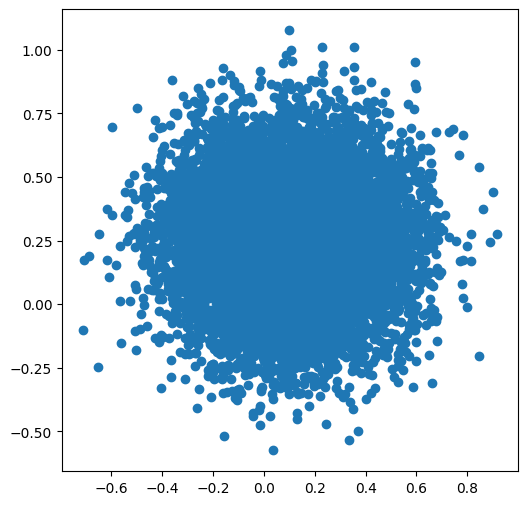

In [7]:
samples = target_dist(10000)
# plot_data(dim, samples, k_true=means)

plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1])
plt.gca().set_aspect('equal')
plt.show()

In [8]:
# 3. Set up the Continuous Normalizing Flow (CNF)
batch_size = 64
model = MLP(dim=dim, time_varying=True)
ode_model = torch_wrapper(model)
solver = "dopri5"
node = NeuralODE(ode_model, solver=solver, sensitivity="adjoint", atol=1e-4, rtol=1e-4)

num_epochs = 10000
optimizer = optim.Adam(model.parameters(), lr=0.001)

 82%|████████▏ | 9/11 [00:00<00:00, 28.77it/s]

10: loss -20.480 time 0.35


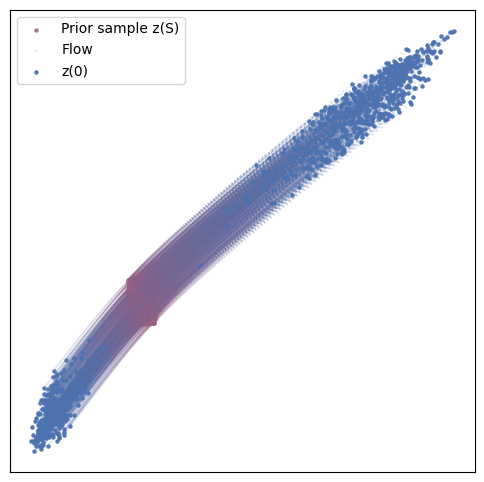

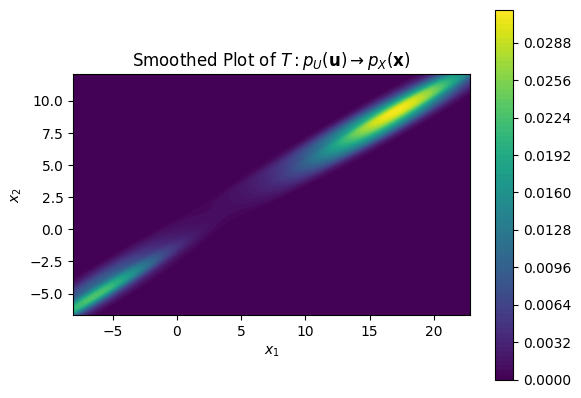

100%|██████████| 11/11 [00:01<00:00,  6.71it/s]


In [15]:
# 4. Define the loss function using the likelihood
def loss_function(theta, x_obs, cnf:CNF_Net, likelihood_func: callable):
    log_likelihood = likelihood_func(theta, x_obs)  # Compute p(x_obs | theta)
    cnf_regularization = cnf.regularization(theta)  # Regularization from CNF
    return -log_likelihood + cnf_regularization

def compute_log_likelihood(base_dist: GeneralDistribution, 
                           xt: torch.Tensor, 
                           log_det_jacobian: torch.Tensor) -> torch.Tensor:
    """
    Compute the log likelihood under a normalizing flow using the base distribution and the flow.
    """
    # In the real function, we will marginalize out all the variables to get just A4, which we will use to compute the likelihood

    # Log probability under the base distribution
    log_p0 = base_dist.log_prob(xt)#.sum(dim=1)
    
    # Total log likelihood
    log_p = log_p0 + log_det_jacobian
    return -log_p.mean()


def train():
    start = time.time()
    # 5. Optimize the CNF using gradient descent
    for k in tqdm(range(11)):
        optimizer.zero_grad()


        z0 = prior_t(prior_dist.sample(batch_size))
        t = torch.rand(batch_size, 1).type_as(z0)

        # Dont need to put z0 through model, because that's what this is doing though the wrapper
        zt = node.trajectory(z0, t_span=torch.linspace(0, 1, 10))[-1]

        log_det_jacobian = torch.sum(torch.log(torch.abs(zt - z0)), dim=1)

        # This is where I would convert the sampled k and the sampled th ph into A_4'
        # I would then compute the likelihood by computing the difference between A_4' and A_4?????     
        # Or, rather, would I use the gaussian_kde method? 
        # loss = loss_function(z0, x_obs)
        loss = compute_log_likelihood(prior_dist, zt, log_det_jacobian)
        
        loss.backward()  # Backpropagation through the ODE using the adjoint method
        optimizer.step()
        if (k + 1) % 10 == 0:
            end = time.time()
            print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
            start = end

            with torch.no_grad():
                prior_samples = prior_t(prior_dist.sample(1000))
                traj = node.trajectory(prior_samples, t_span=torch.linspace(0, 1, 100),)
                plot_trajectories(traj.cpu().numpy())
                plot_smooth_dist(traj.cpu().numpy(), 2000)


with profiler.profile(record_shapes=True) as prof:
    train()

In [16]:
print(prof.key_averages().table(sort_by="cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             aten::selu         0.45%       2.167ms        27.29%     132.889ms      33.866us          3924  
                                              aten::elu        26.84%     130.722ms        26.84%     130.722ms      33.313us          3924  
                                           aten::linear         0.94%       4.576ms        23.17%     112.829ms      21.565us          5232  
                                            aten::addmm        15.70%      76.468ms        20.04%      97.575ms      18.650us          5232  
    au

In [ ]:
# 6. After training, sample from the posterior distribution and plot results
prior_samples = prior_dist(10000)
posterior_samples = model(prior_samples)
plot_data(dim, posterior_samples, k_true=means)

Step 4: Loss Function Using Likelihood:

When computing the loss function during the CNF training, you now have access to the likelihood 
$p(x_{\text{obs}}∣\theta)$, so you can use this information directly.
Instead of only comparing simulated and observed data distributions, you can explicitly include the likelihood in your loss function. For example, you could minimize the negative log-likelihood:
$$
\mathcal{L}=−\log p(x_{\text{obs}}∣\theta)+ \text{CNF regularization terms}
$$
The CNF will learn how to transform the prior distribution to match the posterior distribution by taking the likelihood into account.


Summary:
If you can compute the likelihood 
$p(x_{\text{obs}}∣\theta)$, you can still use CNFs to efficiently approximate and sample from the posterior distribution 
$p(\theta|x_{\text{obs}})$. The likelihood helps guide the CNF's transformation by incorporating it directly into the loss function during training. This combines the flexibility of CNFs for modeling complex posteriors with the information from the likelihood function, resulting in a robust and efficient method for Bayesian inference.

The description in your function suggests you're trying to create a model where:

Forward Model: You generate a value 
A
4​	
  from parameters 
k, 
θ, and 
ϕ (using something like
$A_4=f(k,\theta,\phi)$).
Inverse Model: You want to invert this process, i.e., given 

$A_4, \theta$, and $\phi$, find the corresponding k.
In this case, Continuous Normalizing Flows (CNFs) could be used for the inverse problem (inferring k) if you frame the task as a density estimation problem or a posterior distribution learning problem. Here's how

1. Forward Model as a Likelihood Function:
The forward model 
A
4
=
f
(
k
,
θ
,
ϕ
)
A 
4
​	
 =f(k,θ,ϕ) simulates the data. This function can be seen as producing a likelihood 
p
(
A
4
∣
k
,
θ
,
ϕ
)
p(A 
4
​	
 ∣k,θ,ϕ) for the observed 
A
4
A 
4
​	
 .

2. Using CNFs for the Inverse Problem:
CNFs can learn the inverse mapping by transforming a simple prior distribution on 
k
k into a posterior distribution over 
k
k given 
A
4
A 
4
​	
 , 
θ
θ, and 
ϕ
ϕ.
Here's the setup:
Inputs: 
A
4
A 
4
​	
 , 
θ
θ, 
ϕ
ϕ are given.
Target: You want to infer 
k
k, which could be a continuous parameter.
Flow Learning: You can train a CNF to learn a mapping from a base distribution (like a Gaussian) over 
k
k to a posterior distribution 
p
(
k
∣
A
4
,
θ
,
ϕ
)
p(k∣A 
4
​	
 ,θ,ϕ).


3. How to Do This:
Forward Model: Continue using your forward model 
A
4
=
f
(
k
,
θ
,
ϕ
)
A 
4
​	
 =f(k,θ,ϕ) to generate data.
CNF Training:
Use CNFs to learn the inverse mapping by training on pairs of input parameters
(
A
4
,
θ
,
ϕ
)
(A 
4
​	
 ,θ,ϕ) and output parameters 
k
k.
The CNF will take a sample 
k
k from a simple prior distribution and transform it to match the posterior distribution 
p
(
k
∣
A
4
,
θ
,
ϕ
)
p(k∣A 
4
​	
 ,θ,ϕ).

4. Incorporating CNFs:
You would define a likelihood 
p
(
A
4
∣
k
,
θ
,
ϕ
)
p(A 
4
​	
 ∣k,θ,ϕ) based on the forward model, and the CNF would be trained to map from prior samples over 
k
k to posterior samples conditioned on 
A
4
A 
4
​	
 , 
θ
θ, and 
ϕ
ϕ.
The loss function would be based on minimizing the difference between the true and predicted 
A
4
A 
4
​	
  values, incorporating CNF’s regularization to handle the transformation.

In [ ]:
# Prior distribution over k (Gaussian for simplicity)
def prior_distribution(mean=0, std=1):
    return Normal(loc=mean, scale=std)

In [ ]:
# Process (this can all be done in batches)
# 1. Sample k_{lm} from prior distribution
#
# 2. Sample th, ph from either a prior distribution, or the actual observed data (likely a prior distribtion as to not overconstrain)
#   a. Perhaps, instead, sample a distribution of th, phs and a single k_{lm} 
#   b. This distribution would have to be a simulated GW detection (unsure how to do this with the spherical coordinates)
#
# 3. Calculate A_4 value for that k_{lm}, th, ph 
#
# 4. Update (inverse?) network weights (should I train another CNF?) (maybe an embedded CNF? A CNF on a non-euclidean manifold?) 
# 
# 

# Define the CNF training process
def train_cnf(prior: GeneralDistribution, 
              cnf: nn.Module, 
              observed_data: torch.Tensor, 
              th: torch.Tensor, 
              ph: torch.Tensor, 
              optimizer: optim.optimizer.Optimizer = optim.Adam, 
              num_epochs: int = 1000):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Sample from the prior
        k_samples = prior.sample([observed_data.size(0)])
        
        # Solve the CNF (using an ODE solver) to get the transformed samples
        t = torch.tensor([0., 1.], dtype=torch.float32)  # Time interval for the ODE
        k_transformed = odeint(cnf, k_samples, t)[-1]  # ODE integration
        
        # Use the forward model to simulate A4 values from k_transformed, th, and ph
        a4_simulated = forward_model(k_transformed, th, ph)
        
        # Compute the loss (e.g., negative log-likelihood)
        loss = -torch.mean(torch.log(torch.abs(a4_simulated - observed_data) + 1e-6))
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Print loss every few epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [ ]:
# After training, sample from the posterior distribution
def sample_posterior(cnf: nn.Module, 
                     prior: GeneralDistribution, 
                     num_samples: int = 100):
    # Sample from the prior
    k_prior_samples = prior.sample([num_samples])
    
    # Solve the CNF to transform prior samples to posterior samples
    t = torch.tensor([0., 1.], dtype=torch.float32)
    k_posterior_samples = odeint(cnf, k_prior_samples, t)[-1]
    
    return k_posterior_samples

Common CNF Regularization Terms:
Flow Smoothness Regularization:
CNFs model the transformation as a continuous differential equation. To ensure that the transformations remain smooth over time, you can add a regularization term that penalizes large changes in the ODE network's parameters.
This can be achieved by penalizing the norm of the gradients of the neural network controlling the flow, 
f
(
θ
(
t
)
,
t
)
f(θ(t),t).
Example term:

R
smooth
=
λ
∫
0
1
∥
∇
θ
f
(
θ
(
t
)
,
t
)
∥
2
d
t
R 
smooth
​	
 =λ∫ 
0
1
​	
 ∥∇ 
θ
​	
 f(θ(t),t)∥ 
2
 dt
This term ensures that the flow evolves smoothly over time.
Trace Term in the ODE Solver:
When using continuous normalizing flows, the change of variables formula includes the trace of the Jacobian of the transformation.
This trace term can grow very large or very small, leading to numerical instability. You can add a regularization term to control the magnitude of the trace term and prevent extreme scaling.
Example term:

R
trace
=
λ
∑
t
=
0
1
∣
trace
(
∂
f
(
θ
(
t
)
,
t
)
∂
θ
)
∣
R 
trace
​	
 =λ 
t=0
∑
1
​	
  
​	
 trace( 
∂θ
∂f(θ(t),t)
​	
 ) 
​	
 
This term penalizes large values of the trace of the Jacobian and stabilizes the transformation.
KL-Divergence Regularization:
If you're using variational inference to train the CNF, a common regularization term is the KL-divergence between the learned flow and the prior distribution.
This ensures that the flow doesn’t deviate too far from the prior distribution unless it’s supported by the data.
Example term:

R
KL
=
D
KL
(
q
(
θ
∣
x
obs
)
∥
p
0
(
θ
)
)
R 
KL
​	
 =D 
KL
​	
 (q(θ∣x 
obs
​	
 )∥p 
0
​	
 (θ))
where 
q
(
θ
∣
x
obs
)
q(θ∣x 
obs
​	
 ) is the posterior distribution learned by the CNF, and 
p
0
(
θ
)
p 
0
​	
 (θ) is the prior distribution.
Weight Decay (L2 Regularization):
A general form of regularization that controls the complexity of the neural network parameters 
ϕ
ϕ in the CNF.
This term penalizes large values of the network weights, preventing overfitting and encouraging simpler models.
Example term:

R
L2
=
λ
∥
ϕ
∥
2
R 
L2
​	
 =λ∥ϕ∥ 
2
 
where 
ϕ
ϕ are the weights of the neural network parameterizing the CNF.
